In [1]:
# Importing necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Custom MLP

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# Load CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

100%|██████████| 170498071/170498071 [00:03<00:00, 44333451.61it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
class Perceptron(nn.Module):
  def __init__(self, num_inputs):
    super(Perceptron, self).__init__()
    self.weights = nn.Parameter(nn.init.xavier_uniform_(torch.Tensor(1, num_inputs)))
    self.bias = nn.Parameter((torch.randn(1)))

  def propagate(self, inputs):
    output = torch.dot(inputs, self.weights.view(-1)) + self.bias
    return output

In [ ]:
class MultiLayerPerceptron(nn.Module):
  def __init__(self):
    super(MultiLayerPerceptron, self).__init__()
    self.hidden_layer1 = nn.ModuleList([Perceptron(32*32*3) for i in range(128)])
    self.hidden_layer2 = nn.ModuleList([Perceptron(128) for i in range(64)])
    self.output_layer = nn.ModuleList([Perceptron(64) for i in range(10)])

  def propagate(self, inputs):
        # Flatten the input data
        inputs = inputs.view(-1, 32 * 32 * 3)

        # Store the matrices of weights
        hidden1_weights = torch.stack([(perceptron.weights) for perceptron in self.hidden_layer1])
        hidden1_weights = hidden1_weights.squeeze(dim=1)
        hidden2_weights = torch.stack([(perceptron.weights) for perceptron in self.hidden_layer2])
        hidden2_weights = hidden2_weights.squeeze(dim=1)
        output_weights = torch.stack([(perceptron.weights) for perceptron in self.output_layer])
        output_weights = output_weights.squeeze(dim=1)

        # Store the vectors of biases
        hidden1_bias = torch.stack([(perceptron.bias) for perceptron in self.hidden_layer1])
        hidden1_bias = hidden1_bias.view(-1)
        hidden2_bias = torch.stack([(perceptron.bias) for perceptron in self.hidden_layer2])
        hidden2_bias = hidden2_bias.view(-1)
        output_bias = torch.stack([(perceptron.bias) for perceptron in self.output_layer])
        output_bias = output_bias.view(-1)

        # Creating output list
        outputs_list = []

        for picture, pixels in enumerate(inputs):
          pixels = torch.relu(F.linear(pixels, hidden1_weights, hidden1_bias))
          pixels = torch.relu(F.linear(pixels, hidden2_weights, hidden2_bias))
          outputs_list.append(F.linear(pixels, output_weights, output_bias))

        # Concatenate the output tensors along the 0th dimension
        output = torch.stack(outputs_list)
        return output.squeeze()

In [ ]:
weight_distribution = []
bias_distribution = []

for experiment in range(10):
  # Model Training
  model = MultiLayerPerceptron()
  loss_function = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr = 0.01)
  num_epochs = 10
  num_neurons = 202
  num_parameters = num_neurons*2 # For weights and biases

  weight_history = [[[] for _ in range(num_parameters)] for _ in range(num_epochs)]
  bias_history = [[[] for _ in range(num_parameters)] for _ in range(num_epochs)]

  for epoch in range(num_epochs):
      epoch_loss = 0
      for batch in trainloader:
          images, labels = batch
          optimizer.zero_grad()
          outputs = model.propagate(images)
          loss = loss_function(outputs, labels)
          loss.backward()
          optimizer.step()
          epoch_loss += loss.item()
      for idx, param in enumerate(model.named_parameters()):
          if idx%2!=1:
              weight_history[epoch][idx].append(param[1].data.clone())
          else:
              bias_history[epoch][idx].append(param[1].data.clone())

      print("Epoch:", epoch + 1, " Loss:", epoch_loss / len(trainloader))

  weight_distribution.append(weight_history)
  bias_distribution.append(bias_history)

Epoch: 1  Loss: 1.8069807882504085
Epoch: 2  Loss: 1.5998990352806228
Epoch: 3  Loss: 1.5175522535353365
Epoch: 4  Loss: 1.461864652688546
Epoch: 5  Loss: 1.414556651773965
Epoch: 6  Loss: 1.376351460319041
Epoch: 7  Loss: 1.343456733028602
Epoch: 8  Loss: 1.3131682665451714
Epoch: 9  Loss: 1.2859790863283456
Epoch: 10  Loss: 1.259365850778492
Epoch: 1  Loss: 1.800005993727223
Epoch: 2  Loss: 1.594816978477761
Epoch: 3  Loss: 1.5115607830569566
Epoch: 4  Loss: 1.450099594757685
Epoch: 5  Loss: 1.4002865870742847
Epoch: 6  Loss: 1.3611090648204773
Epoch: 7  Loss: 1.3253483539042266
Epoch: 8  Loss: 1.2962782219852633
Epoch: 9  Loss: 1.2691399670775285
Epoch: 10  Loss: 1.2440455554391416
Epoch: 1  Loss: 1.8173375446778124
Epoch: 2  Loss: 1.6114602498995982
Epoch: 3  Loss: 1.5246510530066917
Epoch: 4  Loss: 1.4645389643166682
Epoch: 5  Loss: 1.4161116790283672
Epoch: 6  Loss: 1.3749906591442236
Epoch: 7  Loss: 1.3393617460642324
Epoch: 8  Loss: 1.3089279942500316
Epoch: 9  Loss: 1.28118916

In [ ]:
# # Model Testing
# correct = 0
# total = 0
# with torch.no_grad():
#   for batch in testloader:
#     images, labels = batch
#     outputs = model.propagate(images)
#     _,predicted = torch.max(outputs.data, 1)
#     total += labels.size(0)
#     correct += (predicted == labels).sum().item()
# accuracy1 = (correct / total)*100
# print(accuracy1, "%")

#Kernel Distribution Estimation

## Gaussian Kernel

In [ ]:
# # Importing the necessary libraries
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.stats import gaussian_kde

# # Bandwidth parameter (adjust this)
# bandwidth = 0.1

# def plot_kde(weights, name):
#     plt.figure(figsize=(8, 4))
#     plt.title(f'{name} - Epoch 1 - 10')

#     for epoch in range(num_epochs):
#         # Create a KDE object with Gaussian kernel
#         kde = gaussian_kde(weights[epoch][0][0], bw_method=bandwidth)

#         # Define a range of x values for the PDF
#         x_values = np.linspace(min(weights[epoch][0][0]), max(weights[epoch][0][0]), 1000)

#         # Calculate the estimated PDF at each x value
#         pdf_values = kde(x_values)

#         # Plot the KDE estimate
#         plt.plot(x_values, pdf_values, label=f'Epoch {epoch + 1}')
#     # plt.title(f'KDE with Gaussian Kernel - Epoch {epoch + 1}')
#     plt.xlabel('Weight')
#     plt.ylabel('Estimated Density')
#     plt.legend()
#     plt.show()

# # Loop through weight distributions for each epoch
# for idx, (name, param) in enumerate(model.named_parameters()):
#   if 'weight' in name:
#       plot_kde([weight_history[i][idx] for i in range(num_epochs)], name)

# KL Divergence of Weight Distributions among Neurons per Layer per Epoch - Averaged over 10 trials

## Standard Deviation

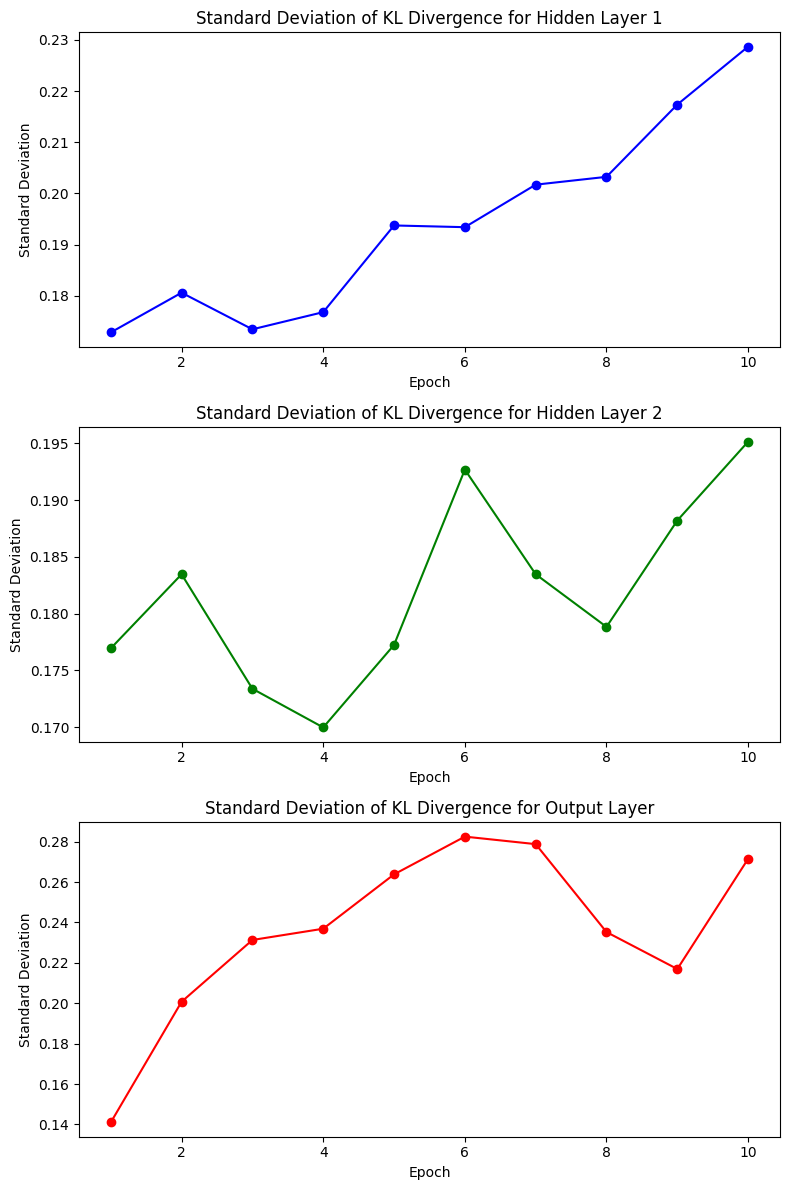

In [ ]:
import matplotlib.pyplot as plt
import torch
from scipy.special import kl_div

# Initialize lists to store standard deviations for each layer across epochs
std_deviations_hidden1 = []
std_deviations_hidden2 = []
std_deviations_output = []

# Loop over each epoch - 10 times
for epoch in range(num_epochs):
    kl_divergences = [[0.0] * 127, [0.0] * 63, [0.0] * 9]  # Store KL divergences for each layer
    for experiment in range(10):
      hidden1_idx = 0
      hidden2_idx = 0
      output_idx = 0
      for idx, (name, param) in enumerate(model.named_parameters()):
          if 'weight' in name:
              if 'hidden_layer1' in name:
                  if idx < 254:
                      # Calculate the KL divergence
                      kl_divergence = kl_div(weight_distribution[experiment][epoch][idx][0][0],
                                            weight_distribution[experiment][epoch][idx + 2][0][0])
                      kl_divergence = [kl.item() for kl in kl_divergence if kl != float('inf')]
                      kl_divergence = sum(kl_divergence)
                      kl_divergences[0][hidden1_idx] += kl_divergence
                      hidden1_idx += 1
              elif 'hidden_layer2' in name:
                  if idx < 382:
                      # Calculate the KL divergence
                      kl_divergence = kl_div(weight_distribution[experiment][epoch][idx][0][0],
                                            weight_distribution[experiment][epoch][idx + 2][0][0])
                      kl_divergence = [kl.item() for kl in kl_divergence if kl != float('inf')]
                      kl_divergence = sum(kl_divergence)
                      kl_divergences[1][hidden2_idx] += kl_divergence
                      hidden2_idx += 1
              elif 'output_layer' in name:
                  if idx < 402:
                      # Calculate the KL divergence
                      kl_divergence = kl_div(weight_distribution[experiment][epoch][idx][0][0],
                                            weight_distribution[experiment][epoch][idx + 2][0][0])
                      kl_divergence = [kl.item() for kl in kl_divergence if kl != float('inf')]
                      kl_divergence = sum(kl_divergence)
                      kl_divergences[2][output_idx] += kl_divergence
                      output_idx += 1

    # Divide each KL divergence by 10 (number of experiments)
    for i in range(3):
        kl_divergences[i] = [kl / 10 for kl in kl_divergences[i]]

    # Calculate the standard deviation for each layer and store it for this epoch
    std_hidden1 = torch.std(torch.tensor(kl_divergences[0]))
    std_hidden2 = torch.std(torch.tensor(kl_divergences[1]))
    std_output = torch.std(torch.tensor(kl_divergences[2]))

    std_deviations_hidden1.append(std_hidden1.item())
    std_deviations_hidden2.append(std_hidden2.item())
    std_deviations_output.append(std_output.item())

# Create subplots for each layer
fig, axs = plt.subplots(3, figsize=(8, 12))

# Plot standard deviation of KL divergence for Hidden Layer 1
axs[0].plot(range(1, num_epochs + 1), std_deviations_hidden1, marker='o', linestyle='-', color='blue')
axs[0].set_title('Standard Deviation of KL Divergence for Hidden Layer 1')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Standard Deviation')

# Plot standard deviation of KL divergence for Hidden Layer 2
axs[1].plot(range(1, num_epochs + 1), std_deviations_hidden2, marker='o', linestyle='-', color='green')
axs[1].set_title('Standard Deviation of KL Divergence for Hidden Layer 2')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Standard Deviation')

# Plot standard deviation of KL divergence for Output Layer
axs[2].plot(range(1, num_epochs + 1), std_deviations_output, marker='o', linestyle='-', color='red')
axs[2].set_title('Standard Deviation of KL Divergence for Output Layer')
axs[2].set_xlabel('Epoch')
axs[2].set_ylabel('Standard Deviation')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


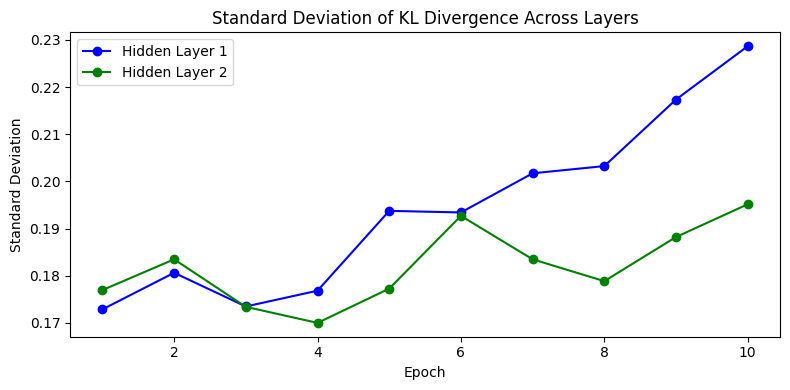

In [ ]:
# Create a single plot for all layers
plt.figure(figsize=(8, 4))

# Plot standard deviation of KL divergence for Hidden Layer 1
plt.plot(range(1, num_epochs + 1), std_deviations_hidden1, marker='o', linestyle='-', color='blue', label='Hidden Layer 1')

# Plot standard deviation of KL divergence for Hidden Layer 2
plt.plot(range(1, num_epochs + 1), std_deviations_hidden2, marker='o', linestyle='-', color='green', label='Hidden Layer 2')

# Plot standard deviation of KL divergence for Output Layer
# plt.plot(range(1, num_epochs + 1), std_deviations_output, marker='o', linestyle='-', color='red', label='Output Layer')

plt.title('Standard Deviation of KL Divergence Across Layers')
plt.xlabel('Epoch')
plt.ylabel('Standard Deviation')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

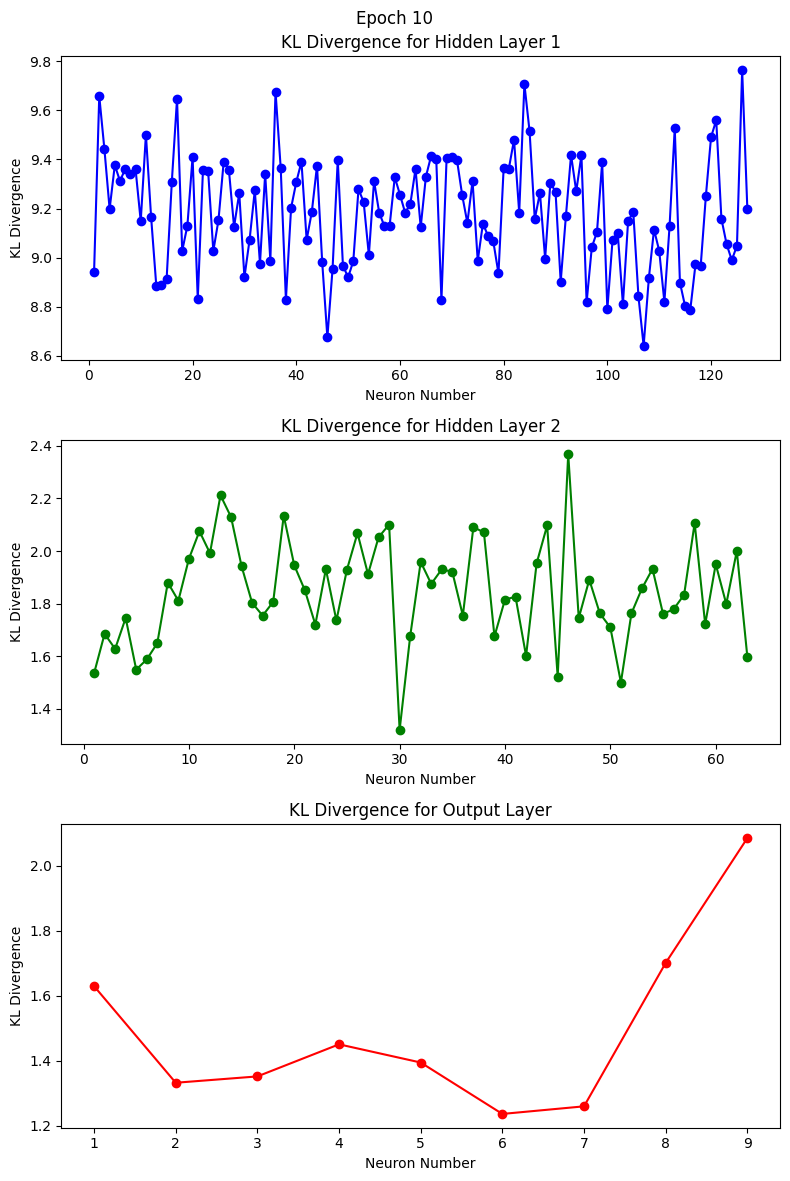

In [ ]:
# Define the neuron numbers
neuron_numbers_hidden1 = range(1, 128)
neuron_numbers_hidden2 = range(1, 64)
neuron_numbers_output = range(1, 10)

# Create subplots for each layer
fig, axs = plt.subplots(3, figsize=(8, 12))

# Plot KL divergences for hidden1 layer
axs[0].plot(neuron_numbers_hidden1, kl_divergences[0], marker='o', linestyle='-', color='blue')
axs[0].set_title('KL Divergence for Hidden Layer 1')
axs[0].set_xlabel('Neuron Number')
axs[0].set_ylabel('KL Divergence')

# Plot KL divergences for hidden2 layer
axs[1].plot(neuron_numbers_hidden2, kl_divergences[1], marker='o', linestyle='-', color='green')
axs[1].set_title('KL Divergence for Hidden Layer 2')
axs[1].set_xlabel('Neuron Number')
axs[1].set_ylabel('KL Divergence')

# Plot KL divergences for output layer
axs[2].plot(neuron_numbers_output, kl_divergences[2], marker='o', linestyle='-', color='red')
axs[2].set_title('KL Divergence for Output Layer')
axs[2].set_xlabel('Neuron Number')
axs[2].set_ylabel('KL Divergence')

# Add a title above all subplots with the epoch number
plt.suptitle(f'Epoch {epoch + 1}')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

466-446 -> 20

# Prebuilt Analysis

In [4]:
# Define a simple feedforward neural network
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 4000)
        self.fc2 = nn.Linear(4000, 1000)
        self.fc3 = nn.Linear(1000, 4000)
        self.fc4 = nn.Linear(4000, 10)


    def forward(self, x):
        x = x.view(-1, 32*32*3)  # Flatten the input
        x = torch.relu(self.fc1(x))
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.fc2(x)
        x = F.dropout(x, p=0.1, training=self.training)
        x = torch.relu(self.fc3(x))
        x = F.dropout(x, p=0.1, training=self.training)
        x = self.fc4(x)
        return x

In [8]:
# Initialize the model, loss function, and optimizer
net = NeuralNetwork()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.001)
num_epochs = 10

# Training loop
for epoch in range(num_epochs):  # Number of epochs
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()  # Zero the parameter gradients

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}')

Epoch 1, Loss: 2.0275439966060316
Epoch 2, Loss: 1.7323583091616326
Epoch 3, Loss: 1.606082004354433
Epoch 4, Loss: 1.5167599253337403
Epoch 5, Loss: 1.4440203206923308
Epoch 6, Loss: 1.377260498988354
Epoch 7, Loss: 1.316597248968261
Epoch 8, Loss: 1.264631565193386
Epoch 9, Loss: 1.2176010248148839
Epoch 10, Loss: 1.1717997880085655


In [ ]:
# Testing the model
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on the test set: {accuracy}%')